<a href="https://colab.research.google.com/github/IzaakGagnon/SSC_GliderProject/blob/main/Test_code/Load_Cluster_Bin_Cross_Validate_Ridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 Read in the data

HD5 has 1/17th the read and write time of csv, since the data size is on the order of 10 million points, these gains are worth while.

First we read in the data files as csv, convert them each to h5, and then combine them both as h5.

# Instructions
Set dataDir to the directory containing the glider files. If the h5 files already exist there, they wont be regenerated.

# If using colab set this true

In [1]:
using_colab = True

### Control binning size

In [14]:
numbins = 1e2
numbins = int(numbins)
numbins

100

# Remember to modify to directory which contains ONLY the .csv raw data

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [4]:

if using_colab:
    # Mount Google Drive in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    # Set your data directory to the correct folder in your Google Drive
    data_dir = '/content/drive/MyDrive/Glider data'
else:
    # Set your local data directory path
    data_dir = '/home/jaiden/Final5P87/data'
file_count = sum(1 for entry in os.listdir(data_dir)
                 if os.path.isfile(os.path.join(data_dir, entry)))
print("Number of files:", file_count)

Mounted at /content/drive
Number of files: 62


In [5]:
!pip install ripser
!pip install persim
!pip install networkx
!pip install scikit-learn
!pip install matplotlib
!pip install tables

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=ed73897755a643550ab2ed5969547b1ac7acdbfc4363058e52e6b16cd4a0c214
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


/content/drive/MyDrive/Glider data
['/content/drive/MyDrive/Glider data/cabot_20210706_135_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/scotia_20220421_150_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/scotia_20190605_100_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/shad_20230601_168_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/scotia_20181113_95_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/sambro_20210705_134_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/fundy_20230726_175_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/cabot_20220727_158_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/peggy_20230417_167_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/peggy_20220421_151_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/fundy_20190604_99_delayed_corrected_v4.csv', '/content/drive/MyDrive/Glider data/cabot_20200717_114_delaye

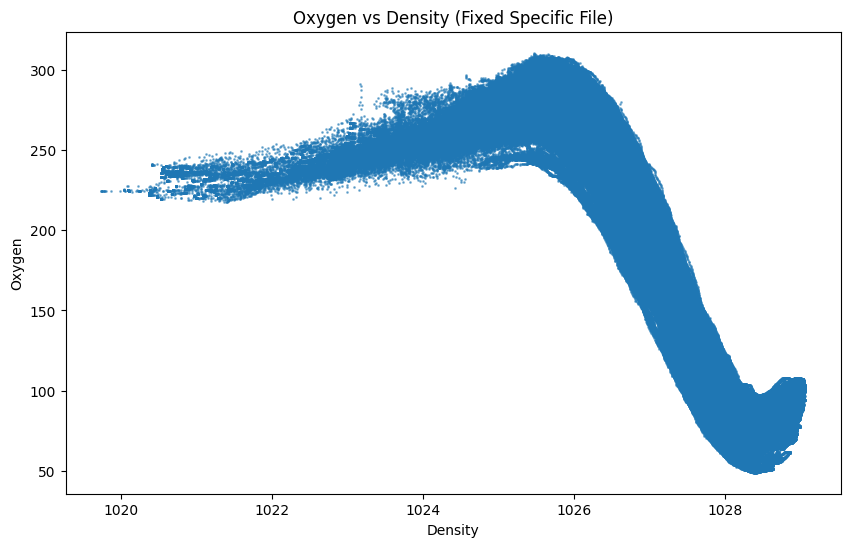


Combining the following HDF5 files:
/content/drive/MyDrive/Glider data/scotia_20220421_150_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/scotia_20190605_100_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/shad_20230601_168_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/scotia_20181113_95_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/sambro_20210705_134_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/fundy_20230726_175_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/cabot_20220727_158_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/peggy_20230417_167_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/peggy_20220421_151_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/fundy_20190604_99_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/cabot_20200717_114_delayed_corrected_v4.h5
/content/drive/MyDrive/Glider data/scotia_20180720_87_delayed_corrected_v4.h5
/content/drive/MyDrive/Gli

In [5]:

print(data_dir)
# ---------------------------
# Step 1: Convert CSV files to HDF5 files
# ---------------------------

# Define data types and chunk size for CSV reading.
dtypes = {
    "longitude": "float32",
    "latitude": "float32",
    "depth": "float32",
    "time": "str",  # Keep as string if date parsing is not required immediately
    "salinity": "float32",
    "density": "float32",
    "temperature": "float32"
}
chunksize = 10**6

def regularize_chunk(chunk):
    """
    Rename columns (if needed), convert numeric columns to float32,
    and remove rows where oxygen is not positive.
    """
    col_mapping = {
        "sea_water_temperature": "temperature",
        "sea_water_practical_salinity": "salinity",
        "sea_water_density": "density",
        "micromoles_of_oxygen_per_unit_mass_in_sea_water": "oxygen"
    }
    chunk.rename(columns=col_mapping, inplace=True)
    for col in ["latitude", "longitude", "depth", "temperature", "salinity", "density", "oxygen"]:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce').astype("float32")
    if "oxygen" in chunk.columns:
        chunk = chunk[chunk["oxygen"] > 0]
    return chunk

csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(csv_files)

for csv_file in csv_files:
    if not csv_file.lower().endswith('.csv'):
        continue
    base_name = os.path.splitext(os.path.basename(csv_file))[0]
    hdf_file = os.path.join(data_dir, base_name + ".h5")
    if os.path.exists(hdf_file):
        print(f"Skipping conversion; {hdf_file} already exists.")
        continue
    print(f"Converting {csv_file} to {hdf_file}...")
    with pd.HDFStore(hdf_file, mode='w') as store:
        for i, chunk in enumerate(pd.read_csv(csv_file, dtype=dtypes, chunksize=chunksize, low_memory=False)):
            chunk = regularize_chunk(chunk)
            store.append('data', chunk, format='table', data_columns=True)
            print(f"  Processed chunk {i} for {csv_file}")
    print(f"Conversion complete for {csv_file}")

# ---------------------------
# Step 2: Clean the specific HDF5 file
# ---------------------------
specific_orig = os.path.join(data_dir, "cabot_20210706_135_delayed_corrected_v4.h5")
specific_fixed = os.path.join(data_dir, "fixed_cabot_20210706_135_delayed_corrected_v4.h5")
if os.path.exists(specific_orig):
    print(f"\nCleaning specific file: {specific_orig}")
    df_specific = pd.read_hdf(specific_orig, key='data')
    initial_count = len(df_specific)

    # Remove rows where density is between 1023.11 and 1023.13 (inclusive)
    df_specific_clean = df_specific[~((df_specific['density'] >= 1023.11) & (df_specific['density'] <= 1023.13))].copy()
    final_count = len(df_specific_clean)
    removed_count = initial_count - final_count
    print(f"Removed {removed_count} data points (from {initial_count} total rows) in the specific file.")

    # Save the cleaned data as a fixed version.
    df_specific_clean.to_hdf(specific_fixed, key='data', mode='w')
    print(f"Cleaned file saved as: {specific_fixed}")

    # Plot Oxygen vs. Density for the fixed file.
    plt.figure(figsize=(10, 6))
    plt.scatter(df_specific_clean['density'], df_specific_clean['oxygen'], s=1, alpha=0.5)
    plt.xlabel("Density")
    plt.ylabel("Oxygen")
    plt.title("Oxygen vs Density (Fixed Specific File)")
    plt.show()
else:
    print(f"Specific file {specific_orig} not found. Skipping cleaning step.")

# ---------------------------
# Step 3: Combine all HDF5 files into one
# ---------------------------
combined_hdf = os.path.join(data_dir, "glider_data.h5")
h5_files = glob.glob(os.path.join(data_dir, "*.h5"))

# If the fixed version exists, exclude the original specific file.
if os.path.exists(specific_fixed):
    h5_files = [f for f in h5_files if os.path.basename(f) != "cabot_20210706_135_delayed_corrected_v4.h5"]
    if specific_fixed not in h5_files:
        h5_files.append(specific_fixed)

print("\nCombining the following HDF5 files:")
for f in h5_files:
    print(f)

# Read each HDF5 file and combine the data.
df_list = []
for h5_file in h5_files:
    try:
        df_temp = pd.read_hdf(h5_file, key='data')
        df_list.append(df_temp)
        print(f"Loaded {len(df_temp)} rows from {h5_file}")
    except Exception as e:
        print(f"Error reading {h5_file}: {e}")

if df_list:
    df_combined = pd.concat(df_list, ignore_index=True)
    df_combined.to_hdf(combined_hdf, key='data', mode='w')
    print(f"\nCombined HDF5 file saved to: {combined_hdf}")
    print("Head of combined data:")
    print(df_combined.head())
else:
    print("No data to combine.")


## Step 2 Cluster data

Initial dataset size: 24031878
Number of sample points used for homology: 1000


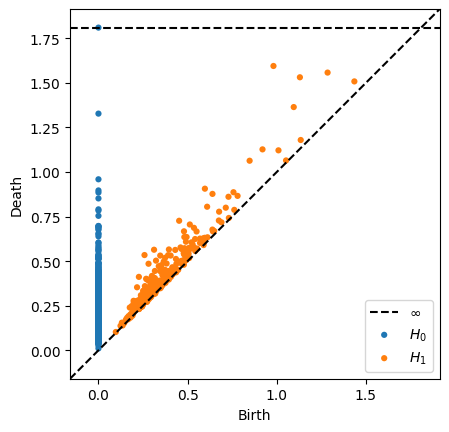

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def split_large_component(component_indices, points, max_size):
    """
    Given a set of indices for a large connected component,
    split it into smaller clusters so that each resulting cluster has at most max_size points.
    """
    component_indices = np.array(list(component_indices))
    num_points = len(component_indices)
    n_clusters = int(np.ceil(num_points / max_size))
    component_points = points[component_indices]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    sub_labels = kmeans.fit_predict(component_points)
    new_clusters = []
    for cl in np.unique(sub_labels):
        indices = component_indices[sub_labels == cl]
        new_clusters.append(set(indices))
    return new_clusters

sample_file = os.path.join(data_dir, 'glider_data.h5')
df = pd.read_hdf(sample_file)
print("Initial dataset size:", df.shape[0])

from sklearn.preprocessing import StandardScaler

# For the sample, we use 5000 rows
df_sample = df.sample(n=1000, random_state=42)
df_sample = df_sample.dropna()
df_sample = df_sample.drop(columns=['time'], errors='ignore')

# Remove the oxygen column because it is our dependent variable.
if 'oxygen' in df_sample.columns:
    df_sample = df_sample.drop(columns=['oxygen'])

# Select only the features for topology: latitude, longitude, and depth.
# (Adjust the order if desired; here we assume columns are named exactly.)
required_features = ['latitude', 'longitude', 'depth', 'salinity', 'density', 'temperature']
if not all(col in df_sample.columns for col in required_features):
    raise ValueError(f"One or more required columns {required_features} not found in the sample data.")

df_features = df_sample[required_features]
scaler = StandardScaler()
points = scaler.fit_transform(df_features.values)
n_points = points.shape[0]
print("Number of sample points used for homology:", n_points)

result = ripser(points, maxdim=1)
diagrams = result['dgms']
plot_diagrams(diagrams, show=True)

In [7]:
threshold_input = input("The persistence diagram is displayed.\nEnter connectivity threshold (e.g., 15): ")
try:
    threshold = float(threshold_input)
except ValueError:
    print("Invalid input. Using default threshold of 15")
    threshold = 15.0
print("Chosen connectivity threshold (epsilon):", threshold)

The persistence diagram is displayed.
Enter connectivity threshold (e.g., 15): 1
Chosen connectivity threshold (epsilon): 1.0


Number of connected components before splitting: 2
Number of components after splitting: 31
Median cluster size: 32.0
Merging clusters smaller than: 1.6
Merging small cluster 30 (size 1) into cluster 27 (size 15)
Full dataset shape before cleaning: (24031878, 8)
Full dataset shape after cleaning: (24031878, 7)
Full dataset cluster assignment complete.
Cluster label counts: {np.int64(-1): np.int64(16656), np.int64(0): np.int64(881694), np.int64(1): np.int64(1894012), np.int64(2): np.int64(483604), np.int64(3): np.int64(951564), np.int64(4): np.int64(767696), np.int64(5): np.int64(776866), np.int64(6): np.int64(881814), np.int64(7): np.int64(946596), np.int64(8): np.int64(761014), np.int64(9): np.int64(1440928), np.int64(10): np.int64(743652), np.int64(11): np.int64(118956), np.int64(12): np.int64(1577844), np.int64(13): np.int64(545936), np.int64(14): np.int64(1433456), np.int64(15): np.int64(764342), np.int64(16): np.int64(139436), np.int64(17): np.int64(768616), np.int64(18): np.int64

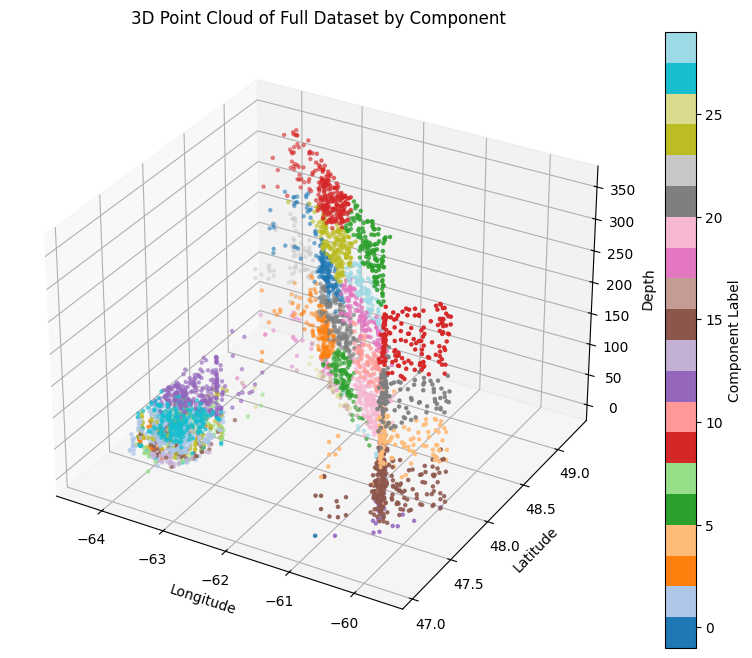

Saved cluster 0 with 881694 points to component_0.h5
Saved cluster 1 with 1894012 points to component_1.h5
Saved cluster 2 with 483604 points to component_2.h5
Saved cluster 3 with 951564 points to component_3.h5
Saved cluster 4 with 767696 points to component_4.h5
Saved cluster 5 with 776866 points to component_5.h5
Saved cluster 6 with 881814 points to component_6.h5
Saved cluster 7 with 946596 points to component_7.h5
Saved cluster 8 with 761014 points to component_8.h5
Saved cluster 9 with 1440928 points to component_9.h5
Saved cluster 10 with 743652 points to component_10.h5
Saved cluster 11 with 118956 points to component_11.h5
Saved cluster 12 with 1577844 points to component_12.h5
Saved cluster 13 with 545936 points to component_13.h5
Saved cluster 14 with 1433456 points to component_14.h5
Saved cluster 15 with 764342 points to component_15.h5
Saved cluster 16 with 139436 points to component_16.h5
Saved cluster 17 with 768616 points to component_17.h5
Saved cluster 18 with 2353

In [18]:
dist_matrix = squareform(pdist(points))
G = nx.Graph()
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i + 1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

components = list(nx.connected_components(G))
print("Number of connected components before splitting:", len(components))

max_size = len(df_sample) / 30  # Adjust this factor as needed.
new_components = []
for comp in components:
    if len(comp) > max_size:
        split_comps = split_large_component(comp, points, max_size)
        new_components.extend(split_comps)
    else:
        new_components.append(comp)
print("Number of components after splitting:", len(new_components))

labels = np.empty(n_points, dtype=int)
for label, comp in enumerate(new_components):
    for idx in comp:
        labels[idx] = label

# Merge clusters that are very small relative to the median cluster size.
cluster_sizes = np.array([len(comp) for comp in new_components])
median_size = np.median(cluster_sizes)
min_size_threshold = 0.05 * median_size  # Merge clusters smaller than 50% of median size.
print("Median cluster size:", median_size)
print("Merging clusters smaller than:", min_size_threshold)

num_clusters = len(new_components)
# Compute centroids for each cluster (using the sample points)
centroids = np.zeros((num_clusters, points.shape[1]))
for i, comp in enumerate(new_components):
    comp_indices = list(comp)
    centroids[i] = np.mean(points[comp_indices], axis=0)

# For each cluster that is too small, merge it into the nearest cluster (by centroid distance)
for i in range(num_clusters):
    if cluster_sizes[i] < min_size_threshold:
        distances = np.linalg.norm(centroids[i] - centroids, axis=1)
        distances[i] = np.inf  # ignore self-distance
        nearest = np.argmin(distances)
        print(f"Merging small cluster {i} (size {cluster_sizes[i]}) into cluster {nearest} (size {cluster_sizes[nearest]})")
        labels[labels == i] = nearest


# Load and preprocess the full dataset.
df_full = pd.read_hdf(sample_file)
print("Full dataset shape before cleaning:", df_full.shape)
df_full = df_full.dropna()
df_full = df_full.drop(columns=['time'], errors='ignore')
print("Full dataset shape after cleaning:", df_full.shape)

# For cluster assignment, use only latitude, longitude, and depth features.
if not all(col in df_full.columns for col in required_features):
    raise ValueError(f"One or more required columns {required_features} not found in the full dataset.")

df_full_features = df_full[required_features]
full_points = scaler.transform(df_full_features.values)

# Build a nearest neighbor model using the sample points (with topology clusters)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points)
distances, indices = nbrs.kneighbors(full_points)
distances = distances.flatten()
indices = indices.flatten()

# For each full dataset point, if its nearest sample point is within the threshold,
# assign the corresponding (merged) cluster label; otherwise, mark as noise (-1).
full_labels = np.where(distances <= threshold, labels[indices], -1)
df_full['component_label'] = full_labels

print("Full dataset cluster assignment complete.")
print("Cluster label counts:", dict(zip(*np.unique(full_labels, return_counts=True))))


# Here we use latitude, longitude, and depth for a 3D plot.
df_full_sample = df_full.sample(n=4000, random_state=42)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_full_sample['longitude'], df_full_sample['latitude'], df_full_sample['depth'],
                c=df_full_sample['component_label'], cmap='tab20', s=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title("3D Point Cloud of Full Dataset by Component")
plt.colorbar(sc, label='Component Label')
plt.show()


unique_clusters = np.unique(full_labels)
unique_clusters = unique_clusters[1:]
count = 0

# Do not include outlier (-1)
for cluster in unique_clusters:
    subset = df_full[df_full['component_label'] == cluster]
    filename = f"component_{count}.h5"
    subset.to_hdf(filename, key='df', mode='w')
    print(f"Saved cluster {cluster} with {len(subset)} points to {filename}")
    destination = f"/content/drive/MyDrive/Glider data/{filename}"
    !mv "/content/{filename}" "{destination}"
    count += 1

## Step 3 Bin data

In [26]:

num_lon_bins = numbins
num_lat_bins = numbins
num_depth_bins = numbins
num_clusters = len(unique_clusters)
def bin_glider_data(input_file, dim_bins = 10):

    df = pd.read_hdf(input_file)

    # Compute bin edges using np.linspace based on the min and max of each variable
    lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), num_lon_bins + 1)
    lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), num_lat_bins + 1)
    depth_bins = np.linspace(df['depth'].min(), df['depth'].max(), num_depth_bins + 1)

    # Create new columns that assign each row to a bin index (0-based)
    df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=False, include_lowest=True)
    df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=False, include_lowest=True)
    df['depth_bin'] = pd.cut(df['depth'], bins=depth_bins, labels=False, include_lowest=True)

    # Create a voxel identifier as a tuple of (lon_bin, lat_bin, depth_bin)
    df['voxel'] = list(zip(df['lon_bin'], df['lat_bin'], df['depth_bin']))

    # Group the data by voxel and compute aggregate statistics, e.g., mean oxygen value
    voxel_grouped = df.groupby('voxel').agg({
        'oxygen': 'mean',
        'longitude': 'mean',
        'latitude': 'mean',
        'depth': 'mean',
        'salinity': 'mean',
        'density': 'mean',
        'temperature': 'mean'
    }).reset_index()


    # Generate output filename
    num_voxels = voxel_grouped.shape[0]
    base_name = os.path.splitext(os.path.basename(input_file))[0]
    output_file = f"{base_name}_binned_{num_voxels}.h5"

    # Save the processed data
    voxel_grouped.to_hdf(output_file, key='data', mode='w')

    print(f"Processed data saved as: {output_file} with {num_voxels} data points")
    return output_file


def process_multiple_files(file_paths, output_directory, dim_bins):
    for input_file in file_paths:

        # Run the binning function for each file
        binned_file = bin_glider_data(input_file, dim_bins)

        # Correct the directory where the file should be saved
        final_binned_file = os.path.join(output_directory, os.path.basename(binned_file))

        # Rename or move the file to the correct directory on Drive
        shutil.move(binned_file, final_binned_file)

        # Print the final saved path
        print(f"Binned data saved as: {final_binned_file}")

        # Check if the file exists at the given path
        if os.path.exists(final_binned_file):
            print(f"The file exists at: {final_binned_file}")
        else:
            print(f"File not found at: {final_binned_file}")

input_files = [f"/content/drive/MyDrive/Glider data/component_{i}.h5" for i in range(num_clusters)]


# Generate folder if it does not exist yet
folder_path = f"/content/drive/My Drive/Glider data/dim_bins{numbins}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder created at: {folder_path}")
else:
    print(f"Folder already exists: {folder_path}")

# Directory where binned files will be saved
output_directory = f"/content/drive/MyDrive/Glider data/dim_bins{numbins}"

# Call the function to process multiple files
process_multiple_files(input_files, output_directory, numbins)


Folder created at: /content/drive/My Drive/Glider data/dim_bins100


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_0_binned_27830.h5 with 27830 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_0_binned_27830.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_0_binned_27830.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_1_binned_56258.h5 with 56258 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_1_binned_56258.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_1_binned_56258.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_2_binned_25053.h5 with 25053 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_2_binned_25053.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_2_binned_25053.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_3_binned_26555.h5 with 26555 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_3_binned_26555.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_3_binned_26555.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_4_binned_31825.h5 with 31825 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_4_binned_31825.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_4_binned_31825.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_5_binned_25498.h5 with 25498 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_5_binned_25498.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_5_binned_25498.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_6_binned_27782.h5 with 27782 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_6_binned_27782.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_6_binned_27782.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_7_binned_54063.h5 with 54063 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_7_binned_54063.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_7_binned_54063.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_8_binned_42528.h5 with 42528 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_8_binned_42528.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_8_binned_42528.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_9_binned_36822.h5 with 36822 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_9_binned_36822.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_9_binned_36822.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')
<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_10_binned_32157.h5 with 32157 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_10_binned_32157.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_10_binned_32157.h5
Processed data saved as: component_11_binned_25248.h5 with 25248 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_11_binned_25248.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_11_binned_25248.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_12_binned_44070.h5 with 44070 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_12_binned_44070.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_12_binned_44070.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_13_binned_24207.h5 with 24207 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_13_binned_24207.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_13_binned_24207.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_14_binned_47991.h5 with 47991 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_14_binned_47991.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_14_binned_47991.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')
<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_15_binned_46716.h5 with 46716 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_15_binned_46716.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_15_binned_46716.h5
Processed data saved as: component_16_binned_13512.h5 with 13512 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_16_binned_13512.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_16_binned_13512.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_17_binned_26320.h5 with 26320 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_17_binned_26320.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_17_binned_26320.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_18_binned_13759.h5 with 13759 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_18_binned_13759.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_18_binned_13759.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_19_binned_32876.h5 with 32876 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_19_binned_32876.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_19_binned_32876.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_20_binned_36791.h5 with 36791 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_20_binned_36791.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_20_binned_36791.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_21_binned_33003.h5 with 33003 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_21_binned_33003.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_21_binned_33003.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_22_binned_19487.h5 with 19487 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_22_binned_19487.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_22_binned_19487.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_23_binned_36466.h5 with 36466 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_23_binned_36466.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_23_binned_36466.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')
<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_24_binned_40903.h5 with 40903 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_24_binned_40903.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_24_binned_40903.h5
Processed data saved as: component_25_binned_12644.h5 with 12644 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_25_binned_12644.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_25_binned_12644.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_26_binned_57206.h5 with 57206 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_26_binned_57206.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_26_binned_57206.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')
<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


Processed data saved as: component_27_binned_16355.h5 with 16355 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_27_binned_16355.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_27_binned_16355.h5
Processed data saved as: component_28_binned_12603.h5 with 12603 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_28_binned_12603.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_28_binned_12603.h5
Processed data saved as: component_29_binned_28327.h5 with 28327 data points
Binned data saved as: /content/drive/MyDrive/Glider data/dim_bins100/component_29_binned_28327.h5
The file exists at: /content/drive/MyDrive/Glider data/dim_bins100/component_29_binned_28327.h5


<ipython-input-26-eb846a52889f>:40: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['voxel'], dtype='object')]

  voxel_grouped.to_hdf(output_file, key='data', mode='w')


In [6]:
import os
import glob
import pandas as pd

# Point this to your folder containing the binned component files
data_dir = "/content/drive/MyDrive/Glider data/dim_bins100"

# Load all HDF5 files starting with "component_" and ending with ".h5"
component_files = sorted(glob.glob(os.path.join(data_dir, "component_*.h5")))
print(f"Found {len(component_files)} component datasets.")

# Load all datasets into memory
datasets = [pd.read_hdf(path) for path in component_files]


Found 30 component datasets.


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

# Assume datasets is a list of preloaded DataFrames
n_datasets = len(datasets)
k = 10  # Number of folds

kf = KFold(n_splits=k, shuffle=True, random_state=42)
dataset_indices = np.arange(n_datasets)

folds = []

for train_indices, test_indices in kf.split(dataset_indices):
    train_df = pd.concat([datasets[i] for i in train_indices], ignore_index=True)
    test_df = pd.concat([datasets[i] for i in test_indices], ignore_index=True)
    folds.append((train_df, test_df))

print(f"Created {len(folds)} dataset-level k-fold splits.")
print(folds)

Created 10 dataset-level k-fold splits.
[(              voxel     oxygen  longitude   latitude       depth   salinity  \
0       (0, 63, 24)  75.140617 -64.265785  49.004593  166.210571  34.092056   
1       (0, 63, 25)  76.870705 -64.265625  49.004513  167.072998  34.097466   
2       (0, 63, 26)  73.905243 -64.265747  49.004574  168.538696  34.112251   
3       (0, 63, 27)  74.416069 -64.265656  49.004532  169.980515  34.125092   
4       (0, 63, 28)  72.841248 -64.265717  49.004559  171.327866  34.136879   
...             ...        ...        ...        ...         ...        ...   
837766  (99, 4, 86)  99.192986 -61.984196  48.504036  338.955566  34.952190   
837767  (99, 4, 87)  99.344070 -61.984173  48.504028  340.040131  34.952423   
837768  (99, 4, 88)  99.464226 -61.984184  48.504032  341.122253  34.951973   
837769  (99, 4, 89)  99.470543 -61.984203  48.504040  342.225769  34.950817   
837770  (99, 4, 90)  99.462929 -61.984203  48.504040  342.969177  34.952457   

         

In [29]:
import numpy as np
from itertools import combinations

n_datasets = len(datasets)
indices = np.arange(n_datasets)
print(indices)
folds = []

for folds in range
test_indices = np.random.choice(indices, size=5, replace=False)
train_indices = [i for i in indices if i not in test_indices]


# Generate all 10-train/4-test combinations
for test_indices in combinations(indices, 5):
    train_indices = [i for i in indices if i not in test_indices]
    train_df = pd.concat([datasets[i] for i in train_indices], ignore_index=True)
    test_df = pd.concat([datasets[i] for i in test_indices], ignore_index=True)
    folds.append((train_df, test_df))

print(f"Created {len(folds)} cross-validation folds.")



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


KeyboardInterrupt: 

Training A Model with this

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# --- Parameters ---
k = 10  # Number of dataset-level folds
alphas = np.logspace(0, 3, 20)  # Grid of alpha values
features = ['longitude', 'latitude', 'depth', 'salinity', 'density', 'temperature']
target = 'oxygen'
# --- Storage for performance metrics ---
test_mse_scores = []
test_r2_scores = []
best_alphas = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(dataset_indices)):
    print(f"\n--- Fold {fold_idx + 1} ---")

    # Combine datasets into train/test sets
    train_df = pd.concat([datasets[i] for i in train_idx], ignore_index=True)
    test_df = pd.concat([datasets[i] for i in test_idx], ignore_index=True)

    # Further split train_df into sub-train and validation for alpha tuning
    subtrain_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

    best_alpha = None
    best_val_mse = float("inf")
    best_model = None

    # Grid search over alphas
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(subtrain_df[features], subtrain_df[target])
        val_preds = model.predict(val_df[features])
        val_mse = mean_squared_error(val_df[target], val_preds)

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_alpha = alpha
            best_model = model

    # Retrain on full training set using best alpha
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(train_df[features], train_df[target])
    test_preds = final_model.predict(test_df[features])

    test_mse = mean_squared_error(test_df[target], test_preds)
    test_r2 = r2_score(test_df[target], test_preds)

    # Store results
    best_alphas.append(best_alpha)
    test_mse_scores.append(test_mse)
    test_r2_scores.append(test_r2)

    print(f"Best alpha: {best_alpha:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

# --- Final summary ---
print("\n=== Cross-Validation Summary ===")
print(f"Average best alpha: {np.mean(best_alphas):.4f}")
print(f"Average Test MSE: {np.mean(test_mse_scores):.4f}")
print(f"Average Test R²: {np.mean(test_r2_scores):.4f}")



--- Fold 1 ---
Best alpha: 54.5559
Test MSE: 721.6458
Test R²: 0.8621

--- Fold 2 ---
Best alpha: 37.9269
Test MSE: 519.7448
Test R²: 0.8949

--- Fold 3 ---
Best alpha: 335.9818
Test MSE: 621.8312
Test R²: 0.7436

--- Fold 4 ---
Best alpha: 1.4384
Test MSE: 566.5591
Test R²: 0.9099

--- Fold 5 ---
Best alpha: 6.1585
Test MSE: 509.5984
Test R²: 0.9083

--- Fold 6 ---
Best alpha: 162.3777
Test MSE: 490.9651
Test R²: 0.7623

--- Fold 7 ---
Best alpha: 483.2930
Test MSE: 848.2982
Test R²: 0.9136

--- Fold 8 ---
Best alpha: 1.4384
Test MSE: 662.3225
Test R²: 0.9235

--- Fold 9 ---
Best alpha: 1.0000
Test MSE: 644.2501
Test R²: 0.3882

--- Fold 10 ---
Best alpha: 233.5721
Test MSE: 813.0734
Test R²: 0.7258

=== Cross-Validation Summary ===
Average best alpha: 131.7743
Average Test MSE: 639.8289
Average Test R²: 0.8032


In [16]:
len(test_df)

82558